In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, vgg16_bn
import torchvision.transforms as transforms


from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torchviz import make_dot

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/'
NUM_CLASSES = 12 # no of classes in the garbage dataset
BATCH_SIZE = 32 # for dataloader
NUM_FOLDS = 4 # for stratified k-fold
LEARNING_RATE = 0.001
NUM_EPOCHS = 4
LOSS_FN = nn.CrossEntropyLoss()

cuda


## Data preparation & pre-processing

In [3]:
# Resize images and normalize pixel values before passing it to the model
transformations = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ])
dataset = ImageFolder(DATASET_DIR, transform = transformations)
CLASSES = dataset.class_to_idx.keys()
print('Total dataset',len(dataset))
print('Classes')
display(dataset.class_to_idx)

Total dataset 15515
Classes


{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

Image sampled from class 0 - "battery"


<Figure size 1008x504 with 0 Axes>

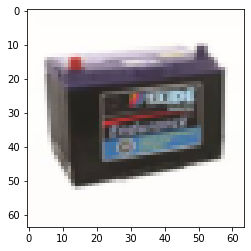

<Figure size 1008x504 with 0 Axes>

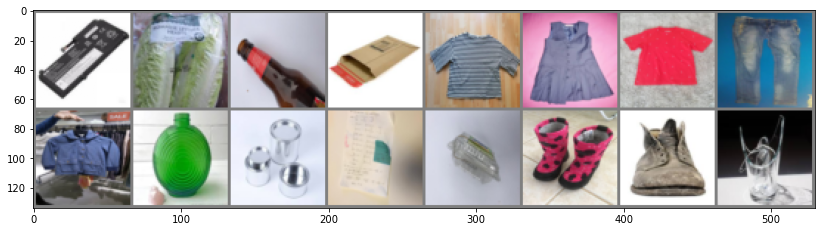

In [4]:
# utility method to print class label(s) and show image(s) of a row in the dataset
def imshow(image):
    plt.figure(figsize=(14,7))
    if not isinstance(image,torch.Tensor):
        plt.figure(figsize=(4,4))
        print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')
        npimg = np.array(image[0])
    else:
        plt.figure(figsize=(14,7))
        npimg = image.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
imshow(dataset[20])
imshow(make_grid([dataset[idx][0] for idx in range(1,len(dataset),1000)]))

In [5]:
all_idxs = np.arange(len(dataset))
# perform a 70/30 train-test stratified split
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)

# get the train and test set targets/labels
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]

# set the test set's dataloader
test_set_loader = DataLoader(Subset(dataset, test_idxs), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 10860
test dataset 4655


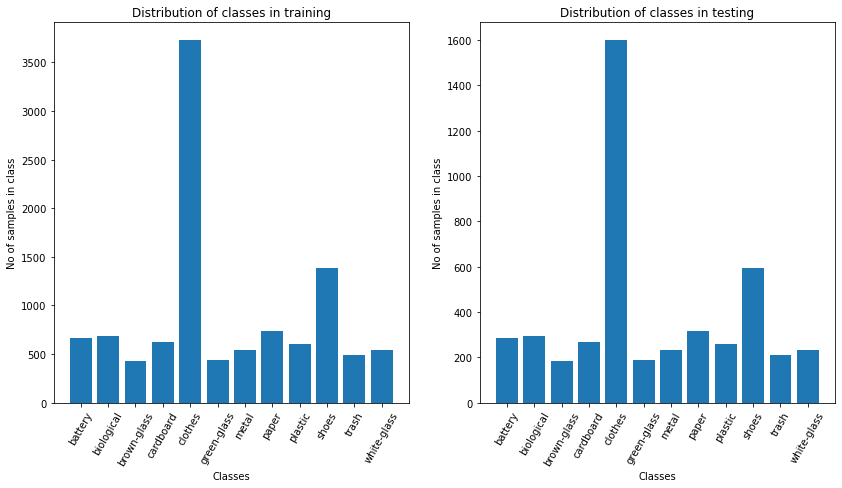

In [6]:
# Plot the distribution of classes in train and test sets
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())
plt.subplot(1,2,2)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());

## Model class definitions

In [7]:
# This cell contains torch models

# 1. A rather shallow CNN to classify
class GarbageClassifierCNN(nn.Module):
    def __init__(self, kernel_size=5, padding=1):
        super(GarbageClassifierCNN, self).__init__()

        # convolutional block #1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        # convolutional block #2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # dense linear layer with ReLU activation
        self.fc = nn.Sequential(
            nn.Linear(14 * 14 * 32, 8*8*8),
            nn.ReLU(inplace=True),
            nn.Linear(8*8*8, NUM_CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 2. Use the pre-trained ResNet model only substituting the final dense layer
class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = resnet50(pretrained=True)
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
            
        self.nn.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, NUM_CLASSES))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.nn(x))

# 3. Use the pre-trained VGG-16 with batch normalization model
class VGG16Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = vgg16_bn(pretrained=True)
        n_features = self.nn.classifier[6].in_features
        
        # Remove final layer
        final_features = list(self.nn.classifier.children())[:-1]
        final_features.extend([nn.Linear(n_features, NUM_CLASSES)])
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
        
        self.nn.classifier = nn.Sequential(*final_features)
    
    def forward(self, x):
        return self.nn(x)

### Method for evaluation on the held-out validation fold

In [8]:
@torch.no_grad()
def evaluate_model(model,loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for _, (images, labels) in enumerate(tqdm(loader)):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

def pretty_print_metrics(metrics):
    print('-- TEST SET METRICS --')
    print(f'Accuracy: {metrics[0]:.3f}%\nF-score: {metrics[1]:.3f}\nRecall: {metrics[2]:.3f}\nPrecision: {metrics[3]:.3f}')

def run_testing(model_to_test):
    model_to_test.load_state_dict(torch.load(f'./{model_to_test.__class__.__name__}-model.pt'))
    model_to_test_conf_mat, model_to_test_metrics = evaluate_model(model_to_test, test_set_loader)
    pretty_print_metrics(model_to_test_metrics)
    plot_cm(np.array(model_to_test_conf_mat), CLASSES)

### Some plotting utilities

In [9]:
# Utility method to plot the confusion matrix over k-folds
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

# Utility method to plot both accuracy vs num epochs and loss vs num epochs
def plot_training_metrics(training_metrics_df):
    fig, ax = plt.subplots(2, figsize=(20,10))

    ax[0].set_xlabel('Number of epochs')
    ax[1].set_xlabel('Number of epochs')
    ax[0].set_ylabel('Training accuracy %')
    ax[1].set_ylabel('Training loss')
    
    for _fold in range(0, NUM_FOLDS):
        temp_df = training_metrics_df.query('fold == @_fold')
        if _fold == 0:
            ax[0].set_title('Training Accuracy vs Number of Epochs')
            ax[1].set_title('Training Loss vs Number of Epochs')
        ax[0].plot(temp_df.epoch.values, temp_df.accuracy.values, label=f'fold-{_fold+1} accuracy')
        ax[1].plot(temp_df.epoch.values, temp_df.loss.values, label=f'fold-{_fold+1} loss')

    ax[0].legend()
    ax[1].legend()

### Method that runs the training loop

In [10]:
# the actual training loop given a model, data loader, optimizer
def training_loop(k_fold_num, model, train_loader, optimizer, total_step):
    epoch_metrics = []

    for epoch in range(NUM_EPOCHS):
        loss_val = 0.0
        acc_val = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = loss.item()
            acc_val = (correct / total) * 100
            
            epoch_metrics.append({'fold':k_fold_num,'epoch':epoch + (i/total_step),'loss':loss_val, 'accuracy':acc_val})
            
            print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')

    torch.save(model.state_dict(), f'./{model.__class__.__name__}-model.pt')
    return epoch_metrics

### Method that runs k-fold cross-validation

In [11]:
def run_kfold(model):
    total_scores = []
    total_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))
    
    # a stratified k-fold splitter instance with NUM_FOLDS
    kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)
    
    epoch_metrics_df = pd.DataFrame(columns=['fold','epoch','loss','accuracy'])
    
    # iterate over each fold
    for k_fold_num, (train_index, test_index) in enumerate(kf.split(train_idxs,train_labels)):
        model.to(device) # push training to either GPU/CPU
        
        print('Running K-Fold cross-validation on fold-', k_fold_num+1)
        
        train_fold = Subset(dataset, train_idxs[train_index])
        test_fold = Subset(dataset, train_idxs[test_index])

        train_loader = DataLoader(train_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
        total_step = len(train_loader)

        # run training
        epoch_metrics = training_loop(k_fold_num, model, train_loader, optimizer, total_step)
        epoch_metrics_df = epoch_metrics_df.append(epoch_metrics, ignore_index=True)
        # run evaluation on validation fold 
        conf_matrix, scores = evaluate_model(model,test_loader)

        total_scores.append(scores)
        total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)
        
        # reset model parameters when going to the next fold
        if k_fold_num != NUM_FOLDS-1:
            model = model.__class__()
            
    scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])

    return scores_df, epoch_metrics_df, total_confusion_matrix

## Use the pretrained ResNet model (with final layer substitution)

In [ ]:
# use the resnet classifier to classify
scores_df, epoch_metrics_df, total_confusion_matrix = run_kfold(ResNetClassifier())

Confusion matrix, without normalization


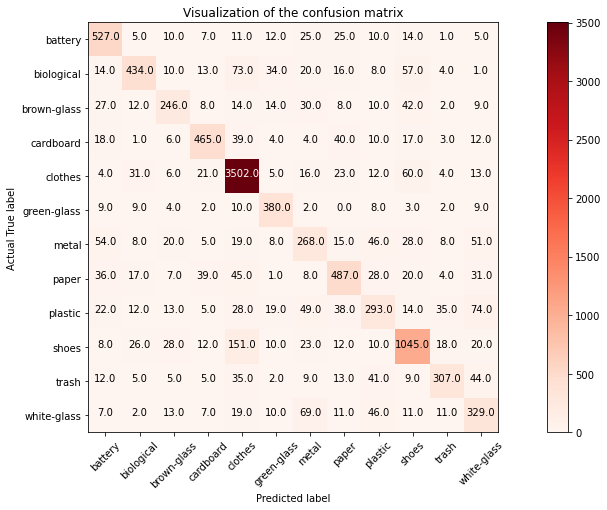

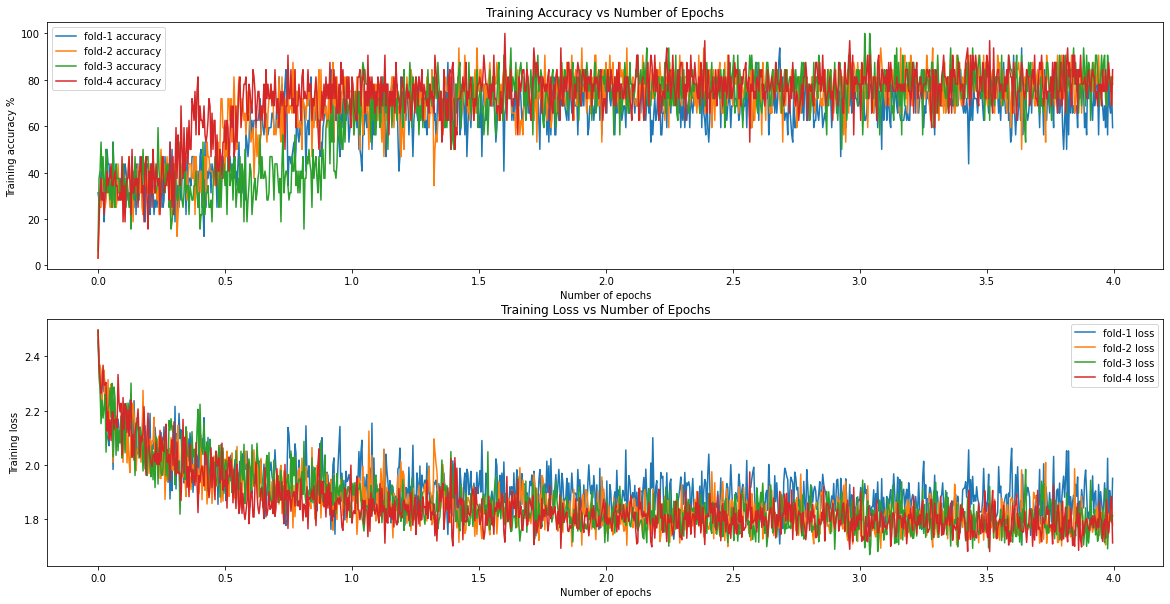

In [13]:
# plot the confusion matrix and the training metrics
plot_cm(total_confusion_matrix, CLASSES)
plot_training_metrics(epoch_metrics_df)

100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [01:46<00:00,  1.36it/s]


-- TEST SET METRICS --
Accuracy: 79.763%
F-score: 0.734
Recall: 0.734
Precision: 0.740
Confusion matrix, without normalization


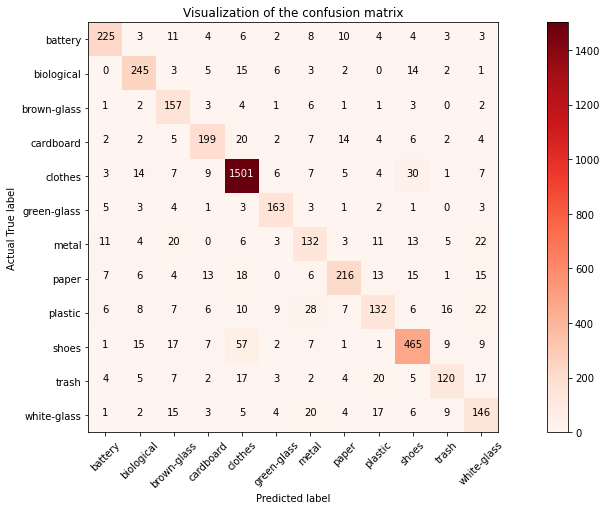

In [14]:
# test the model on the test set
run_testing(ResNetClassifier())

## Using the VGG-16 model (with final layer substitution)

In [ ]:
# use the simpler VGG16Classifier to classify
scores_df,epoch_metrics_df, total_confusion_matrix = run_kfold(VGG16Classifier())

Confusion matrix, without normalization


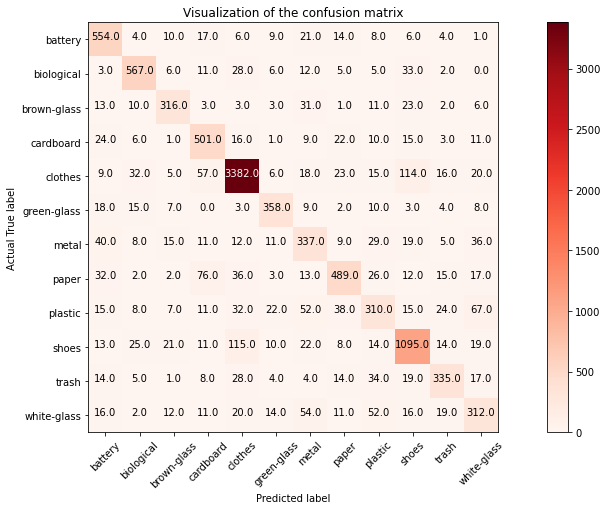

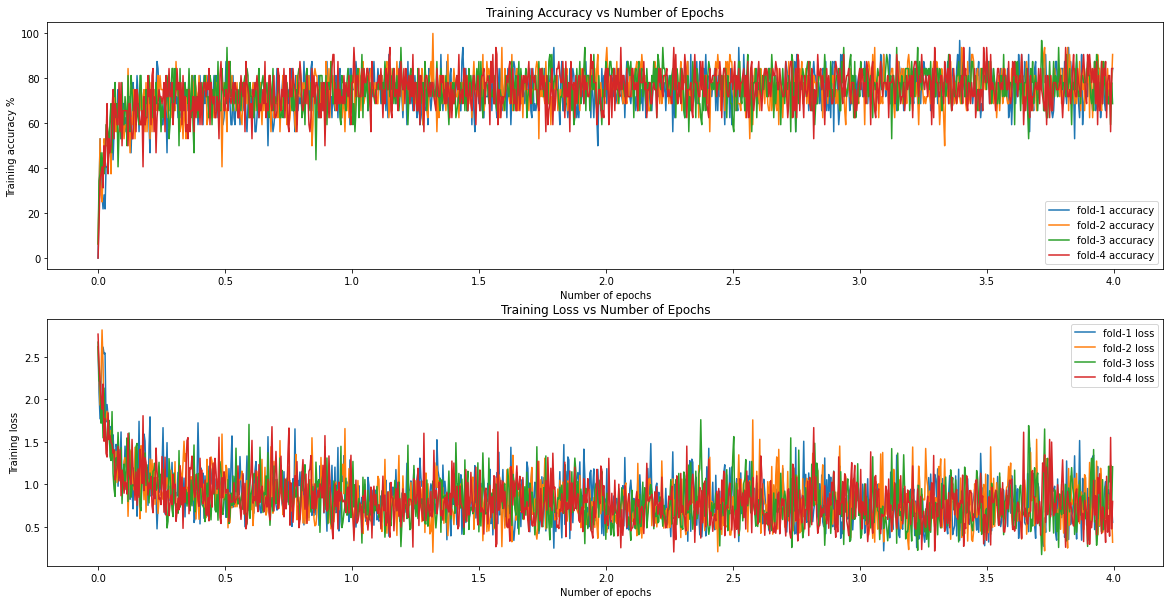

In [16]:
# plot the confusion matrix and the training metrics
plot_cm(total_confusion_matrix, CLASSES)
plot_training_metrics(epoch_metrics_df)

100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [02:15<00:00,  1.07it/s]


-- TEST SET METRICS --
Accuracy: 79.246%
F-score: 0.735
Recall: 0.738
Precision: 0.747
Confusion matrix, without normalization


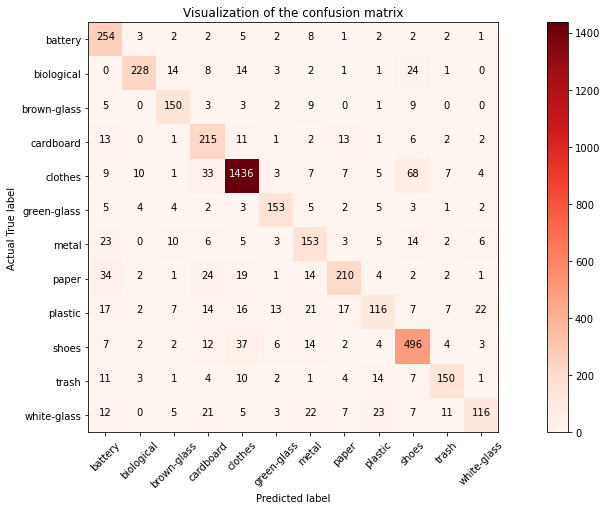

In [17]:
# test the model on the test set
run_testing(VGG16Classifier())

## Using the custom CNN

In [ ]:
# use the simpler GarbageClassifierCNN to classify
scores_df,epoch_metrics_df, total_confusion_matrix = run_kfold(GarbageClassifierCNN())

Confusion matrix, without normalization


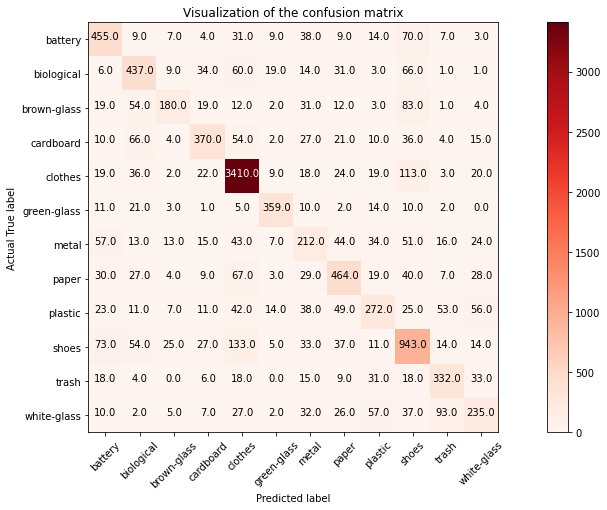

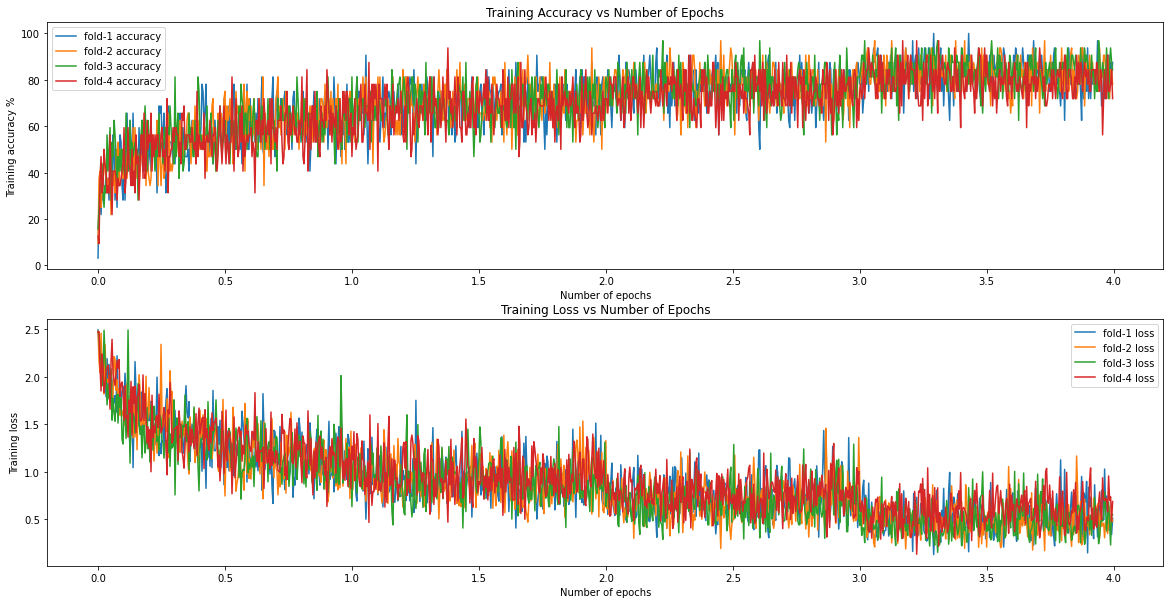

In [19]:
# plot the confusion matrix and the training metrics
plot_cm(total_confusion_matrix, CLASSES)
plot_training_metrics(epoch_metrics_df)

100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [00:19<00:00,  7.31it/s]


-- TEST SET METRICS --
Accuracy: 69.720%
F-score: 0.606
Recall: 0.592
Precision: 0.655
Confusion matrix, without normalization


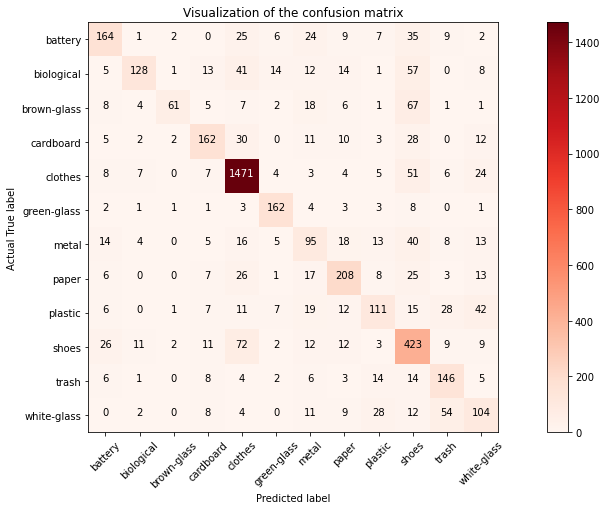

In [20]:
# test the model on the test set
run_testing(GarbageClassifierCNN())

,actual,predicted
0,clothes,clothes
1,clothes,clothes
2,green-glass,green-glass
3,clothes,clothes
4,battery,battery
5,biological,metal
6,cardboard,cardboard
7,paper,paper


<Figure size 1008x504 with 0 Axes>

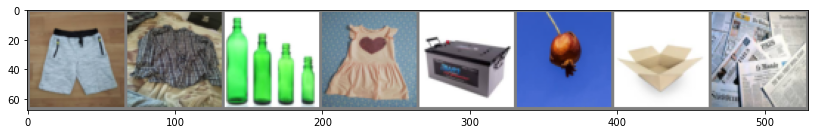

In [60]:
def show_unseen_garbage(garbage_model):
    garbage_model.load_state_dict(torch.load(f'./{garbage_model.__class__.__name__}-model.pt'))
    unseen_garbage_batch = next(iter(test_set_loader))
    garbage_images, actual_garbage_labels = unseen_garbage_batch
    garbage_model.eval()
    imshow(make_grid(garbage_images[:8]))
    garbage_output = garbage_model(garbage_images)
    _, predicted_garbage_labels = torch.max(garbage_output.data, 1)
    
    for actual, predicted in zip(actual_garbage_labels,predicted_garbage_labels):
        yield dataset.classes[actual],dataset.classes[predicted]
pd.DataFrame(show_unseen_garbage(GarbageClassifierCNN()),columns={'actual','predicted'}).head(8)